# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np
import seaborn as sns
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *

In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Import Data 

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-15 06:11:12.699399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 06:11:12.699485: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 06:11:12.699510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-15 06:11:12.699777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [4]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'

emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
               input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

2022-03-15 06:11:12.820145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
embed = hub.load(handle)
embeddings = embed(["man","woman"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 3.9687425e-01, -6.3695002e-01, -6.7363518e-01, -1.3100165e-01,
         5.2906036e-01,  2.3391739e-01, -1.7667708e-01,  1.0469885e+00,
         1.5244880e+00,  8.3604610e-01, -7.9439002e-01,  1.0453002e-01,
        -2.2940248e-02, -1.4738902e-01, -8.3987337e-01,  1.0697368e+00,
        -4.5744944e-01, -4.4647139e-01, -1.3669002e+00,  1.6243970e-01],
       [ 4.5780963e-01, -6.5106559e-01, -4.7487444e-01, -1.3545550e-01,
         7.5560737e-01,  1.3068053e-01, -2.7652311e-01,  1.2009813e+00,
         1.6298714e+00,  1.1437336e+00, -6.3142008e-01,  6.7427382e-04,
        -3.1341049e-01, -2.5012997e-01, -8.7322730e-01,  7.1451533e-01,
        -4.2308569e-01, -7.8139108e-01, -1.1334857e+00,  1.6536513e-01]],
      dtype=float32)>

## Baseline

In [6]:
epochs = 100

base_model = keras.Sequential([
        layers.Input(shape=(), name="Input", dtype=tf.string),
        emb_layer,
        layers.Dense(10,activation='relu', dtype=tf.float32),
        layers.Dropout(0.2),
        layers.Dense(1,activation=relu_advanced)],name='2.1-Baseline-Regularized')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mse','mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
1351/1351 [==============================] - 10s 7ms/step - loss: 5.6371 - mse: 5.6371 - mae: 1.7842 - val_loss: 2.3165 - val_mse: 2.3165 - val_mae: 0.9742
Epoch 2/100
1351/1351 [==============================] - 8s 6ms/step - loss: 2.5038 - mse: 2.5038 - mae: 1.0117 - val_loss: 1.8717 - val_mse: 1.8717 - val_mae: 0.8206
Epoch 3/100
1351/1351 [==============================] - 9s 6ms/step - loss: 2.0359 - mse: 2.0359 - mae: 0.8814 - val_loss: 1.6875 - val_mse: 1.6875 - val_mae: 0.7705
Epoch 4/100
1351/1351 [==============================] - 9s 6ms/step - loss: 1.8273 - mse: 1.8273 - mae: 0.8261 - val_loss: 1.5647 - val_mse: 1.5647 - val_mae: 0.7415
Epoch 5/100
1351/1351 [==============================] - 9s 7ms/step - loss: 1.6758 - mse: 1.6758 - mae: 0.7888 - val_loss: 1.4800 - val_mse: 1.4800 - val_mae: 0.7277
Epoch 6/100
1351/1351 [==============================] - 9s 7ms/step - loss: 1.5589 - mse: 1.5589 - mae: 0.7649 - val_loss: 1.4173 - val_mse: 1.4173 - val_mae: 0.72

In [7]:
test1 = 'I like the top but it took long to deliver'
test2 = 'This app is trash'
test3 = 'Where am I'
test4 = 'I Love this App'
print(f'"{test1}" receives a score of', base_model.predict([test1]).ravel())
print(f'"{test2}" receives a score of', base_model.predict([test2]).ravel())
print(f'"{test3}" receives a score of', base_model.predict([test3]).ravel())
print(f'"{test4}" receives a score of', base_model.predict([test4]).ravel())

"I like the top but it took long to deliver" receives a score of [3.0914848]
"This app is trash" receives a score of [1.4758865]
"Where am I" receives a score of [2.964842]
"I Love this App" receives a score of [5.]


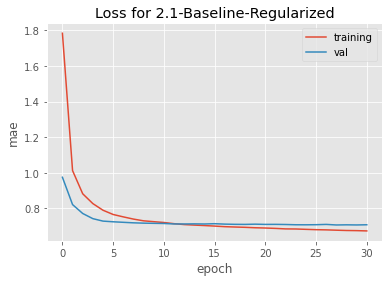

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-Baseline-Regularized.png


In [8]:
plot_loss(base_history,base_model)

The prediction values range between [0.] and [5.]
Mean Absolute Error: 0.7084118347917162


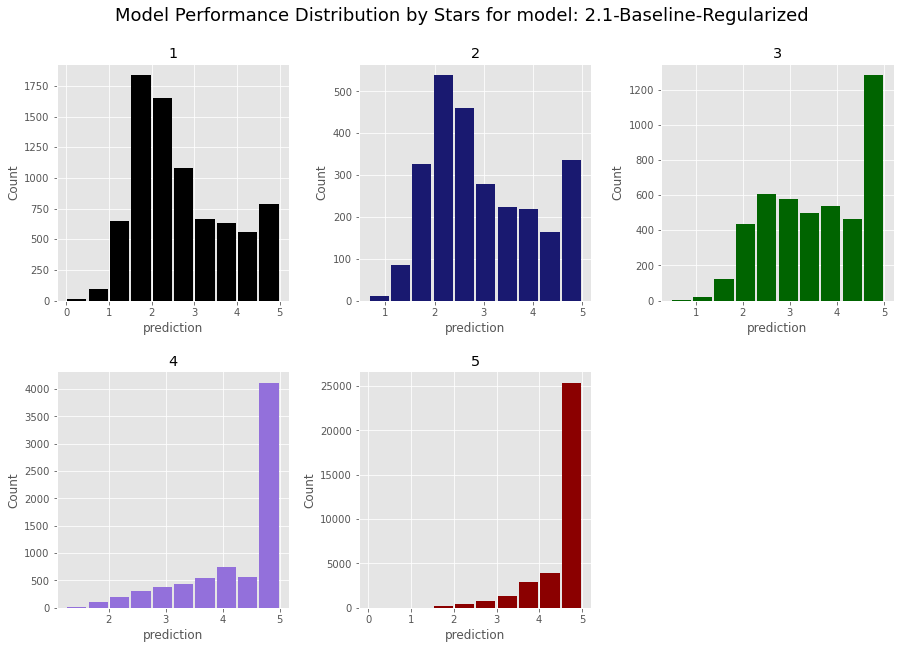

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


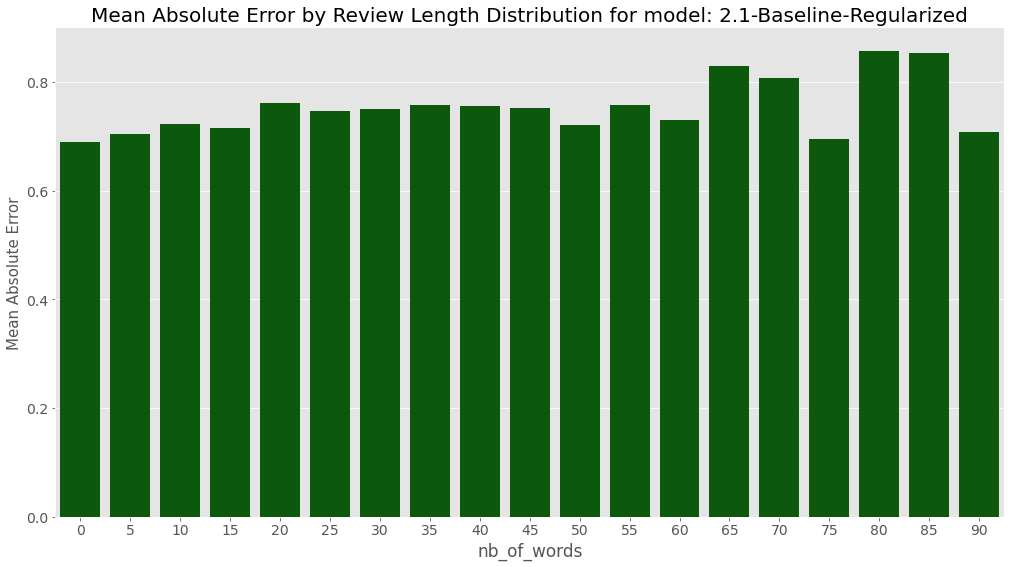

Performance appended successfully.
Done


In [9]:
performance_evaluation(X_test, y_test, base_model)

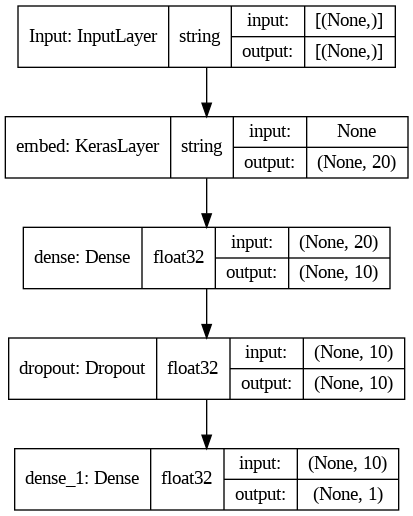

In [12]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [13]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-Baseline-Regularized/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-Baseline-Regularized/assets


## RNN

In [14]:
embed
embed(X_train).shape

TensorShape([172839, 20])

In [38]:
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.SimpleRNN(10, activation='tanh',return_sequences=True)),
    layers.SimpleRNN(5, activation='tanh',return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-RNN-Regularized-Bidirectional')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 30s 21ms/step - loss: 2.9126 - mse: 2.9126 - mae: 1.2769 - val_loss: 1.3590 - val_mse: 1.3590 - val_mae: 0.6976
Epoch 2/100
1351/1351 [==============================] - 28s 21ms/step - loss: 1.3525 - mse: 1.3525 - mae: 0.7242 - val_loss: 1.4146 - val_mse: 1.4146 - val_mae: 0.6741
Epoch 3/100
1351/1351 [==============================] - 29s 21ms/step - loss: 1.2193 - mse: 1.2193 - mae: 0.6523 - val_loss: 1.4296 - val_mse: 1.4296 - val_mae: 0.6651
Epoch 4/100
1351/1351 [==============================] - 28s 21ms/step - loss: 1.1554 - mse: 1.1554 - mae: 0.6280 - val_loss: 1.3922 - val_mse: 1.3922 - val_mae: 0.6799
Epoch 5/100
1351/1351 [==============================] - 29s 21ms/step - loss: 1.0962 - mse: 1.0962 - mae: 0.6149 - val_loss: 1.3691 - val_mse: 1.3691 - val_mae: 0.6774
Epoch 6/100
1351/1351 [==============================] - 29s 21ms/step - loss: 1.0581 - mse: 1.0581 - mae: 0.6105 - val_loss: 1.3483 - val_mse: 1.3483 - va

In [39]:
rnn_model.summary()

Model: "2.1-RNN-Regularized-Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (KerasLayer)           (None, 20)                389380    
_________________________________________________________________
reshape_15 (Reshape)         (None, 20, 1)             0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 20, 20)            240       
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 5)                 130       
_________________________________________________________________
dropout_14 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 6         
Total params: 389,756
Trainable params: 389,756
Non-trainable params: 0
___________________________

In [40]:
test1 = 'I like the top but it took long to deliver'
test2 = 'This app is trash'
test3 = 'Where am I'
test4 = 'I Love this App'
print(f'{test1} receives a score of', rnn_model.predict([test1]).ravel())
print(f'{test2} receives a score of', rnn_model.predict([test2]).ravel())
print(f'{test3} receives a score of', rnn_model.predict([test3]).ravel())
print(f'{test4} receives a score of', rnn_model.predict([test4]).ravel())

I like the top but it took long to deliver receives a score of [2.7139125]
This app is trash receives a score of [1.0445702]
Where am I receives a score of [3.8490872]
I Love this App receives a score of [5.]


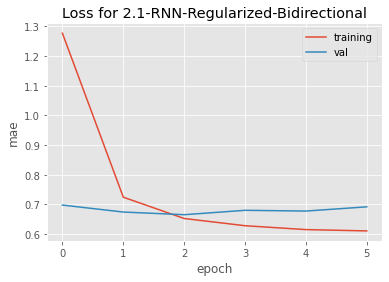

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-RNN-Regularized-Bidirectional.png


In [41]:
plot_loss(rnn_history,rnn_model)

The prediction values range between [0.] and [5.]
Mean Absolute Error: 0.6915399455056641


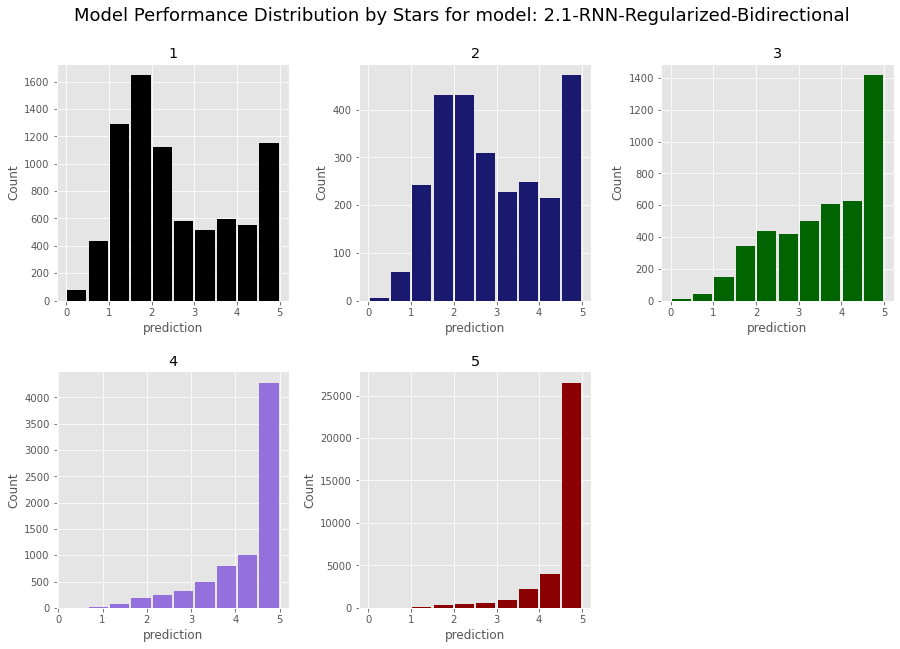

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


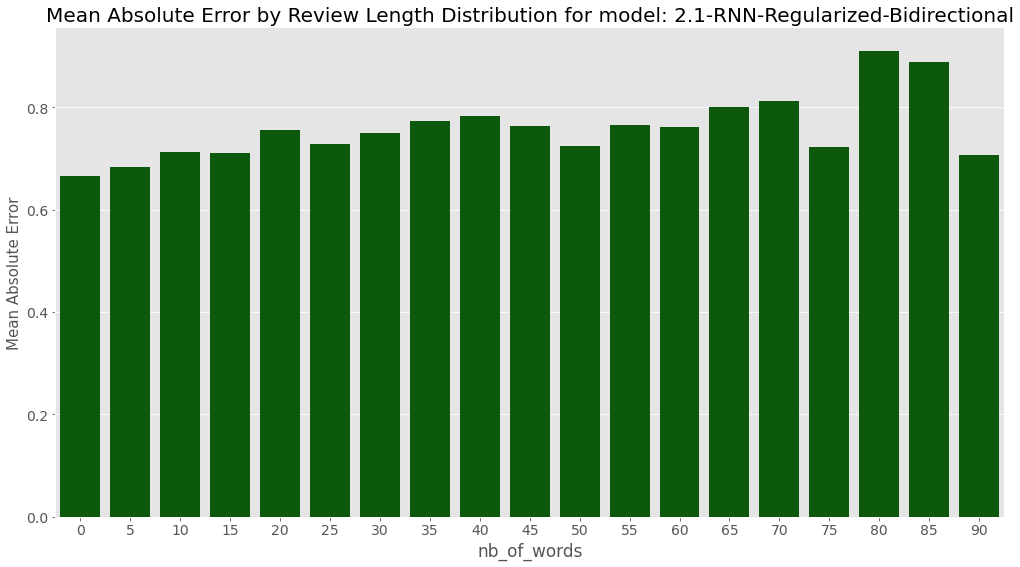

Performance appended successfully.
Done


In [42]:
performance_evaluation(X_test, y_test, rnn_model)

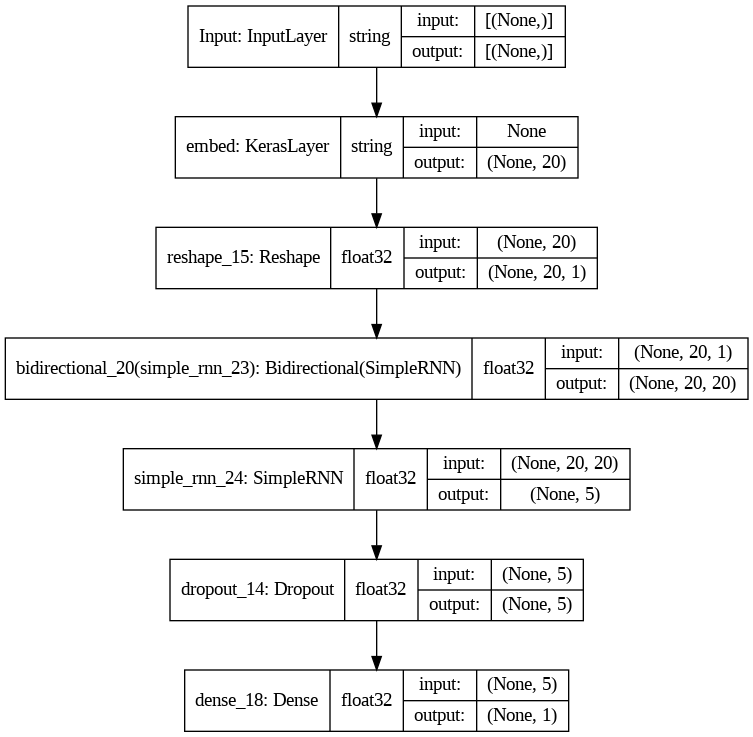

In [43]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [44]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-RNN-Regularized-Bidirectional/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-RNN-Regularized-Bidirectional/assets


In [21]:
# max(y_pred)

In [48]:
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.GRU(10, activation='tanh',return_sequences=True)),
    layers.GRU(4, activation='tanh',return_sequences=False),
    layers.Dropout(0.2),
    # layers.Dense(5,activation='relu'),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-GRU-Regularization-Bidirectional')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 49s 33ms/step - loss: 3.4916 - mse: 3.4916 - mae: 1.4901 - val_loss: 1.2753 - val_mse: 1.2753 - val_mae: 0.8279
Epoch 2/100
1351/1351 [==============================] - 43s 32ms/step - loss: 1.5724 - mse: 1.5724 - mae: 0.8236 - val_loss: 1.3571 - val_mse: 1.3571 - val_mae: 0.6798
Epoch 3/100
1351/1351 [==============================] - 44s 33ms/step - loss: 1.3548 - mse: 1.3548 - mae: 0.7130 - val_loss: 1.3516 - val_mse: 1.3516 - val_mae: 0.6719
Epoch 4/100
1351/1351 [==============================] - 44s 33ms/step - loss: 1.2430 - mse: 1.2430 - mae: 0.6662 - val_loss: 1.3366 - val_mse: 1.3366 - val_mae: 0.6718
Epoch 5/100
1351/1351 [==============================] - 44s 32ms/step - loss: 1.1677 - mse: 1.1677 - mae: 0.6448 - val_loss: 1.3280 - val_mse: 1.3280 - val_mae: 0.6795
Epoch 6/100
1351/1351 [==============================] - 49s 36ms/step - loss: 1.1066 - mse: 1.1066 - mae: 0.6254 - val_loss: 1.3246 - val_mse: 1.3246 - va

In [49]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-GRU-Regularization-Bidirectional/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-GRU-Regularization-Bidirectional/assets


In [50]:
test1 = 'I like the top but it took long to deliver'
test2 = 'This app is trash'
test3 = 'Where am I'
test4 = 'I Love this App'
print(f'"{test1}" receives a score of', gru_model.predict([test1]).ravel())
print(f'"{test2}" receives a score of', gru_model.predict([test2]).ravel())
print(f'"{test3}" receives a score of', gru_model.predict([test3]).ravel())
print(f'"{test4}" receives a score of', gru_model.predict([test4]).ravel())

"I like the top but it took long to deliver" receives a score of [3.458137]
"This app is trash" receives a score of [0.76187634]
"Where am I" receives a score of [4.187912]
"I Love this App" receives a score of [5.]


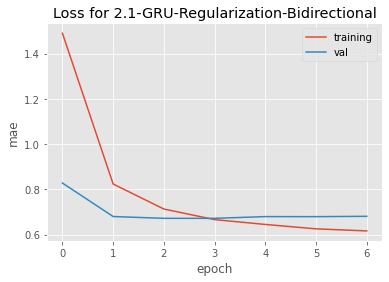

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-GRU-Regularization-Bidirectional.png


In [51]:
plot_loss(gru_history,gru_model)

The prediction values range between [0.09572077] and [5.]
Mean Absolute Error: 0.6789726222239902


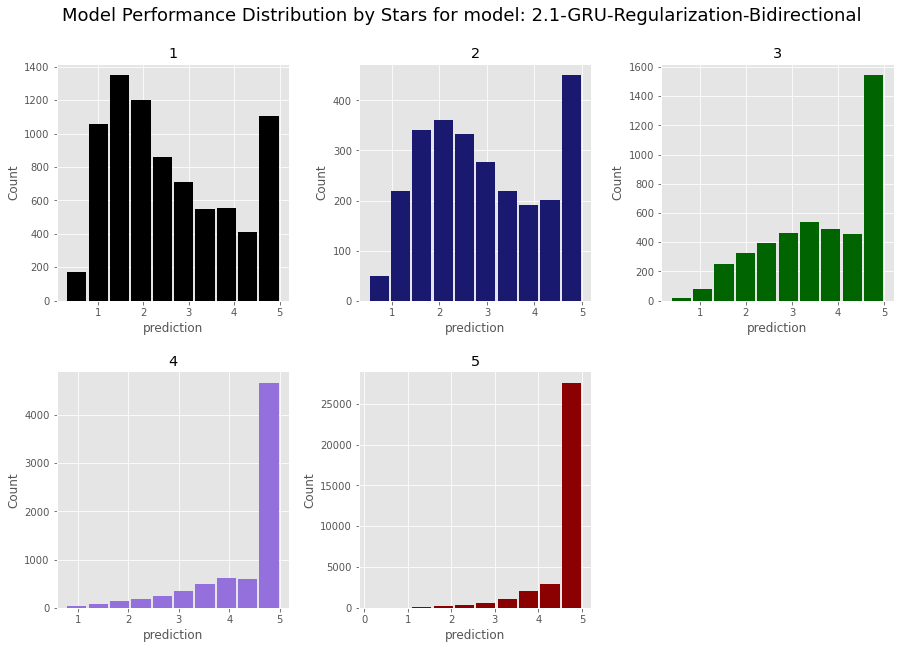

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


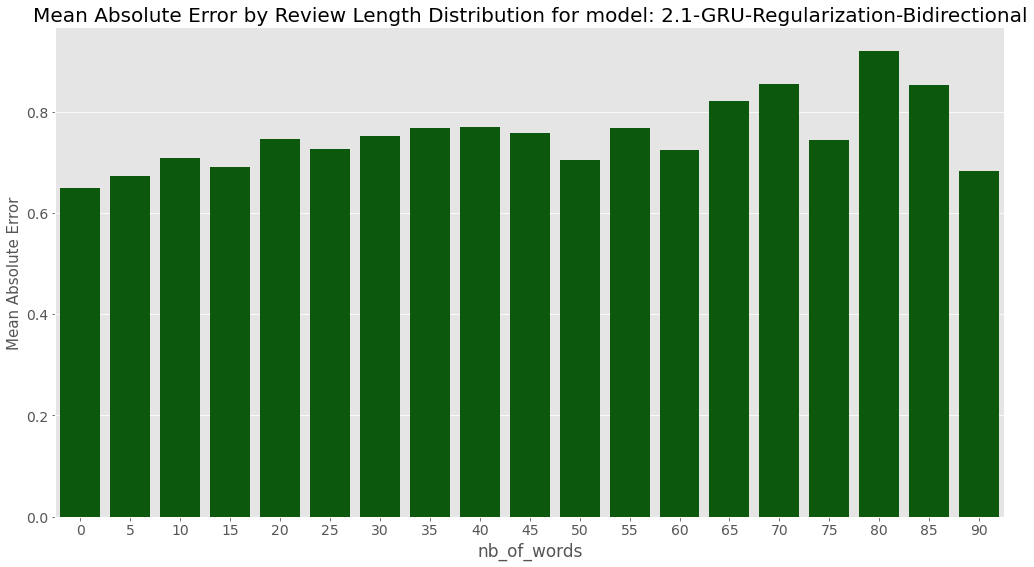

Performance appended successfully.
Done


In [52]:
performance_evaluation(X_test, y_test, gru_model)

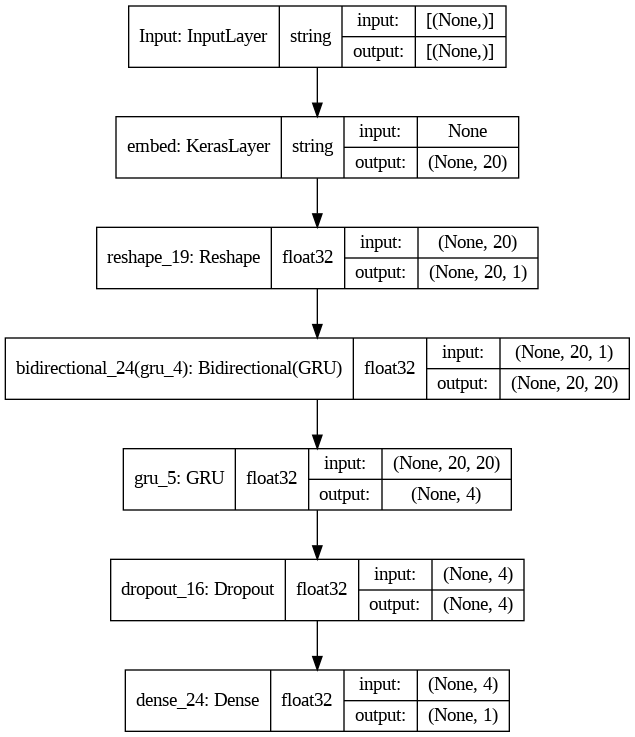

In [53]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## LSTM

In [56]:
lstm_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.LSTM(10, activation='tanh',return_sequences=True)),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    # layers.Dense(5,activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-LSTM-Regularization-Bidirectional')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 46s 31ms/step - loss: 2.1147 - mse: 2.1147 - mae: 0.9918 - val_loss: 1.3299 - val_mse: 1.3299 - val_mae: 0.6867
Epoch 2/100
1351/1351 [==============================] - 46s 34ms/step - loss: 1.2012 - mse: 1.2012 - mae: 0.6542 - val_loss: 1.3343 - val_mse: 1.3343 - val_mae: 0.6708
Epoch 3/100
1351/1351 [==============================] - 46s 34ms/step - loss: 1.1449 - mse: 1.1449 - mae: 0.6254 - val_loss: 1.3297 - val_mse: 1.3297 - val_mae: 0.6725
Epoch 4/100
1351/1351 [==============================] - 46s 34ms/step - loss: 1.1032 - mse: 1.1032 - mae: 0.6052 - val_loss: 1.3347 - val_mse: 1.3347 - val_mae: 0.6729
Epoch 5/100
1351/1351 [==============================] - 48s 35ms/step - loss: 1.0738 - mse: 1.0738 - mae: 0.5958 - val_loss: 1.3440 - val_mse: 1.3440 - val_mae: 0.6852


The prediction values range between [1.067406] and [5.]
Mean Absolute Error: 0.6827703237475633


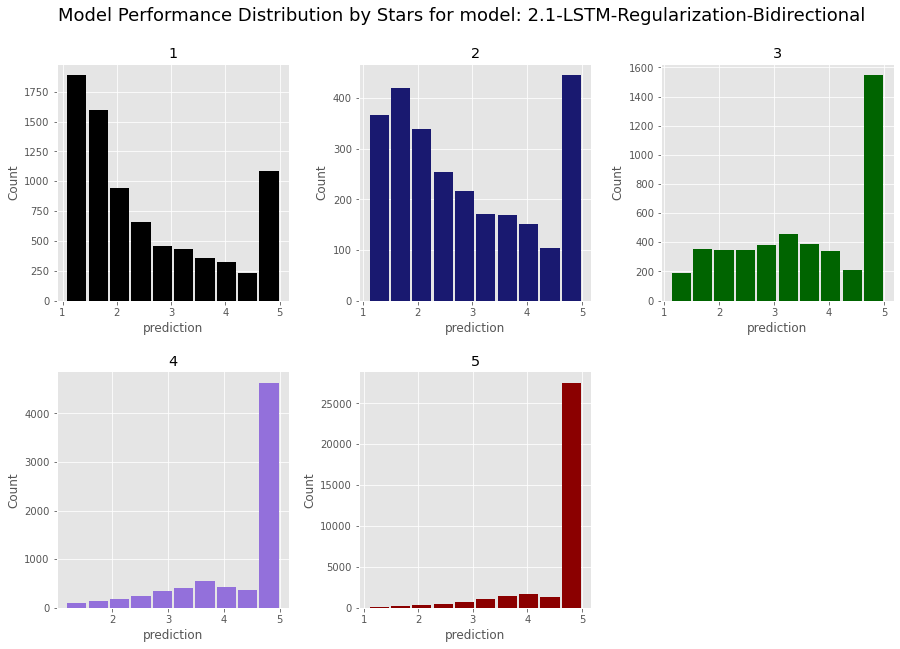

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


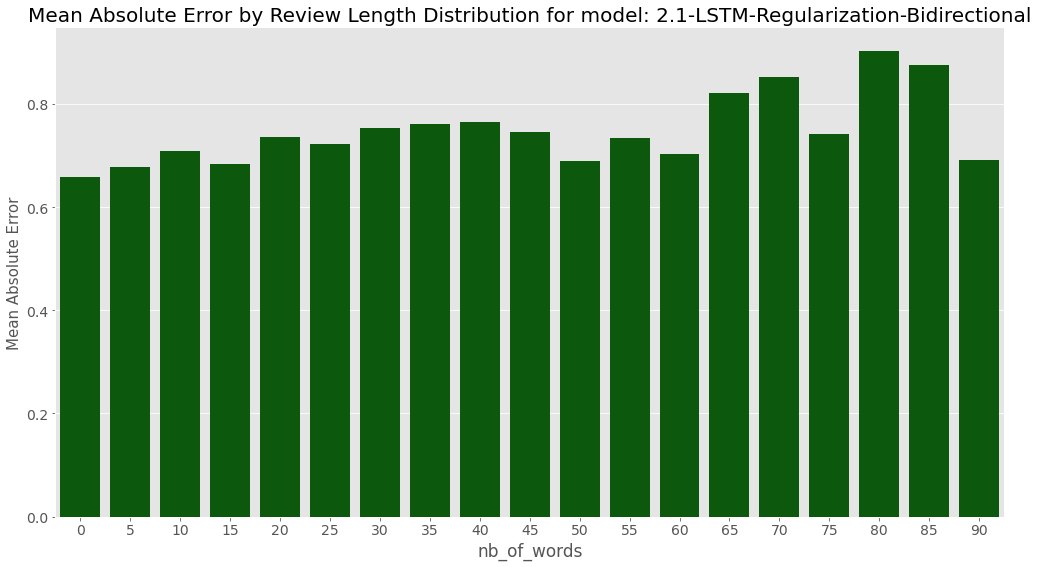

Performance appended successfully.
Done


In [58]:
performance_evaluation(X_test, y_test, lstm_model)

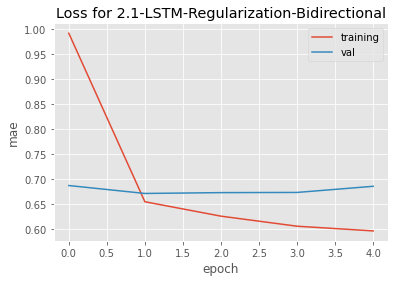

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-LSTM-Regularization-Bidirectional.png


In [57]:
plot_loss(lstm_history,lstm_model)

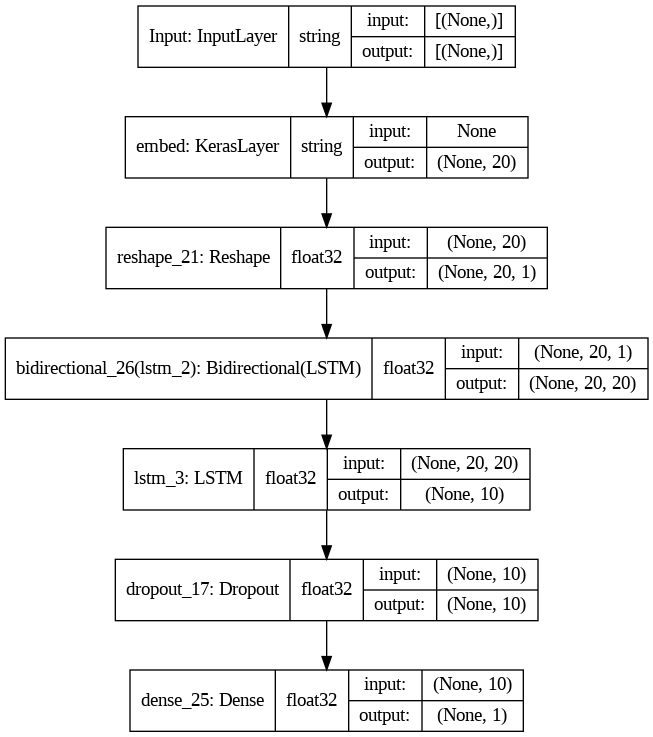

In [59]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [60]:
test1 = 'I like the top but it took long to deliver'
test2 = 'This app is trash'
test3 = 'Where am I'
test4 = 'I Love this App'
print(f'"{test1}" receives a score of', lstm_model.predict([test1]).ravel())
print(f'"{test2}" receives a score of', lstm_model.predict([test2]).ravel())
print(f'"{test3}" receives a score of', lstm_model.predict([test3]).ravel())
print(f'"{test4}" receives a score of', lstm_model.predict([test4]).ravel())

"I like the top but it took long to deliver" receives a score of [3.895968]
"This app is trash" receives a score of [1.2264155]
"Where am I" receives a score of [4.4474907]
"I Love this App" receives a score of [5.]


In [61]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM-Regularization-Bidirectional/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM-Regularization-Bidirectional/assets
